In [1]:
import os.path as osp
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve

sys.path.append("../src")
from score_utils import load_features, transform_features, calc_projection_matrices
from score_utils import load_fc_layer, split_val_test_idxs, calc_probs, calc_regret_on_set
from main_score import load_ind_products, load_ood_products, calc_gram_pref, calc_pnml_pref


In [2]:
# Plot params
# mpl.style.use("seaborn-dark")
mpl.style.use("ggplot")
mpl.rcParams["axes.grid"] = True
mpl.rcParams["legend.frameon"] = True
mpl.rcParams["figure.dpi"] = 85
mpl.rcParams["axes.labelsize"] = "large"
# plt.rcParams["ytick.major.size"] = 5.0
# plt.rcParams["ytick.minor.size"] = 3.0
plt.rcParams["legend.framealpha"] = 0.9
w, h = plt.rcParams.get('figure.figsize')


In [3]:
# densenet cifar100 LSUN(C)
root = osp.join("..", "outputs", "gram_densenet_cifar100_20210102_101209")
trainset_name = 'cifar100'
ood_name = "LSUN"
# ood_name = "Gaussian"


In [4]:
# Initialize output

# Load trainset products
trainset_features = load_features(osp.join(root, f"trainset_features.npy"))
trainset_features = transform_features(trainset_features)
p_parallel, p_bot = calc_projection_matrices(trainset_features)
w = load_fc_layer(root)

# Load IND products
ind_features, ind_labels, probs_ind = load_ind_products(root, trainset_name)

# Score gram
ind_gram_dev_path = osp.join(root, f"{trainset_name}_gram_deviations.npy")
gram_deviations_ind = np.load(ind_gram_dev_path, allow_pickle=True)

# Score pNML
ind_features = transform_features(ind_features)
probs_ind = calc_probs(ind_features, w)

# Load OOD products
ood_dicts = load_ood_products(root, trainset_name)

ood_dict = ood_dicts.pop(ood_name)

# Load ood products
ood_features = load_features(ood_dict["feature_path"])
ood_features = transform_features(ood_features)
ood_probs = calc_probs(ood_features, w)
deviations_ood = np.load(ood_dict["gram_dev_path"])

# Split
test_indices, val_indices = split_val_test_idxs(len(gram_deviations_ind), seed=1)
deviations_ind_val = gram_deviations_ind[val_indices]
deviations_ind_test = gram_deviations_ind[test_indices]

# Compute Gram
dev_norm_sum = deviations_ind_val.sum(axis=0, keepdims=True) + 10 ** -7
ind_deviations_norm = (deviations_ind_test / dev_norm_sum).mean(axis=1)
ood_deviations_norm = (deviations_ood / dev_norm_sum).mean(axis=1)

# Calc metric pnml
gram_performance_dict = calc_gram_pref(ood_name, ind_deviations_norm, ood_deviations_norm)

# Compute pNML
dev_norm_std = deviations_ind_val.std(axis=0, keepdims=True)
dev_norm_std[dev_norm_std == 0.0] = 1.0
ind_deviations_norm = np.sqrt((deviations_ind_test / dev_norm_std).mean(axis=1, keepdims=True))
ood_deviations_norm = np.sqrt((deviations_ood / dev_norm_std).mean(axis=1, keepdims=True))
regrets_ind, pnml_prediction = calc_regret_on_set(
    ind_features[test_indices] * ind_deviations_norm, probs_ind[test_indices], p_parallel, p_bot
)

# Calc metric pnml
regrets_ood, _ = calc_regret_on_set(
    ood_features * ood_deviations_norm, ood_probs, p_parallel, p_bot
)

pnml_performance_dict = calc_pnml_pref(ood_name, regrets_ind, regrets_ood)

print("Gram")
print(gram_performance_dict)
print("pNML")
print(pnml_performance_dict)


Gram
{'TNR at TPR 95%': 65.08, 'AUROC': 91.34209388888888, 'Detection Acc.': 83.53111111111112, 'ood_dataset': 'LSUN'}
pNML
{'TNR at TPR 95%': 76.24, 'AUROC': 94.49107888888888, 'Detection Acc.': 87.26055555555557, 'ood_dataset': 'LSUN'}


In [5]:
# regret 
labels = [1] * len(regrets_ind) + [0] * len(regrets_ood)
scores = 1 - np.append(regrets_ind, regrets_ood)
fpr, tpr, thresholds = roc_curve(labels, scores)
detection_acc = 0.5 * (tpr + 1 - fpr).max()
detection_acc_idx = np.argmax(0.5 * (tpr + 1 - fpr))
best_threhsold = thresholds[detection_acc_idx]
regret_threshold = 1 - best_threhsold
print(regret_threshold)

labels = [1] * len(ind_deviations_norm) + [0] * len(ood_deviations_norm)
scores = 1 - np.append(ind_deviations_norm, ood_deviations_norm)
fpr, tpr, thresholds = roc_curve(labels, scores)
detection_acc = 0.5 * (tpr + 1 - fpr).max()
detection_acc_idx = np.argmax(0.5 * (tpr + 1 - fpr))
best_threhsold = thresholds[detection_acc_idx]
gram_threshold = 1 - best_threhsold
print(gram_threshold)


0.0024313545606211573
0.5117367506027222


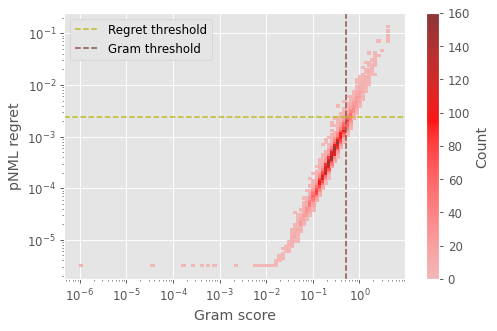

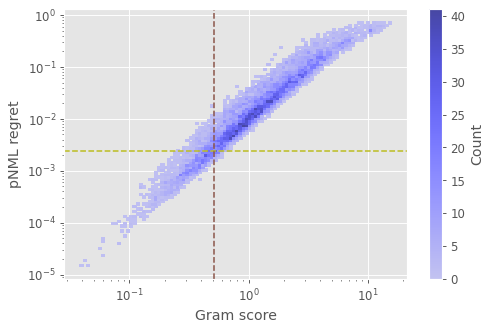

In [22]:
ind_deviations_norm_plot = ind_deviations_norm.squeeze()
ind_deviations_norm_plot += 1e-30
regrets_ind_plot = regrets_ind
regrets_ind_plot += 1e-30
sns.histplot(
    x=ind_deviations_norm_plot,
    y=regrets_ind_plot,
    bins=100,
    discrete=(False, False),
    log_scale=(True, True),
    cbar=True,
    color="r",
    cbar_kws={"label": "Count"},
)
plt.axhline(
    y=regret_threshold, color="tab:olive", linestyle="--", linewidth=1.3, label="Regret threshold"
)
plt.axvline(
    x=gram_threshold, color="tab:brown", linestyle="--", linewidth=1.3, label="Gram threshold"
)
plt.xlabel("Gram score")
plt.ylabel("pNML regret")
plt.legend()
plt.tight_layout()
plt.savefig("../outputs/visualizations/ind_hist.pdf")
plt.show()

sns.histplot(
    x=ood_deviations_norm.squeeze(),
    y=regrets_ood,
    bins=100,
    discrete=(False, False),
    log_scale=(True, True),
    cbar=True,
    cbar_kws={"label": "Count"},
    color="b",
)
plt.xlabel("Gram score")
plt.ylabel("pNML regret")
# plt.xscale('symlog')
# plt.yscale('log')
# plt.xlim(0.0, 16.0)
# plt.ylim(0.0, 1.0)
plt.axhline(
    y=regret_threshold, color="tab:olive", linestyle="--", linewidth=1.3, label="Regret threshold"
)
plt.axvline(
    x=gram_threshold, color="tab:brown", linestyle="--", linewidth=1.3, label="Gram threshold"
)
plt.tight_layout()
plt.savefig("../outputs/visualizations/ood_hist.pdf")
plt.show()
